# **Fitting a SIRD model based on real data**

>Throught two previous Notebooks, the SIRD epidemic model's implementation has been treated. \\
>However, the several simulations were done randomly just to test the model. \\
>Our purpose is now to adjust the model's parameters to fit each situation in order to observe relevant results and draw relevant conclusions based on the reality.

## Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import optimize

## Implementation of the SIRD model

### Differential equations

>The SIRD model is based on 4 equations:

$$ \begin{split}
   \frac{dS(t)}{dt} & = \frac{-\beta I(t) S(t)}{P} \\
   \frac{dI(t)}{dt} & = \frac{\beta I(t) S(t)}{P} -\gamma I(t) -{\mu I(t)}\\
   \frac{dR(t)}{dt} & = \gamma I(t) \\
   \frac{{dD(t)}}{{dt}} & = {\mu I(t)} \\
   \end{split} $$

In [ ]:
# The SIRD model differential equations.
def SIRD(y, t, N, Beta, Gamma, Mu):
    S, I, R, D = y
    dSdt = -(Beta * I * S)/N
    dIdt = (Beta * I * S)/N  - Gamma * I - Mu * I
    dRdt = Gamma * I
    dDdt = Mu * I
    return dSdt, dIdt, dRdt, dDdt

### Formatting results

In [ ]:
#Saving the simulation results

def SIRDsim(y0, t, N, theta):
  
  #Transmission rate
  Beta = theta[0]
  #Recovery rate per day
  Gamma = theta[1]
  #Mortality rate
  Mu = theta[2]

  # Integrate the SIRD equations over the time grid t.
  result = odeint(SIRD, y0, t, args=(N, Beta, Gamma, Mu))
  S, I, R, D = result.T
  return S, I, R, D

## Parameters' estimation

>The model being implemented, the goal is now to create a method to define precisely this model's parameters.

To estimate the parameters of the model $\mathbf{\beta}$, $\mathbf{\gamma}$, and $\mathbf{\mu}$, the least squares method can be used. This method is based on the following equation:

$$ min_{\theta}= \sum_{k=1}^{K}(y_m(k) - y_s(\theta,k))^2 $$

where $y_m(k)$ represents the real data in each sample $k$; $y_s(\theta,k)$ the estimated value from the model simulation for a given sample $k$ and $\theta$ the parametric vector  ($\theta = [ \beta \; \; \gamma \; \; \mu]^T$). 

This equation solve the question: what are the values of $\beta$, $\gamma$ and $\mu$ that minimize the quadratic error when compared to the actual data.

In [ ]:
#Translation of the problem into code

def QuadraticError(Sd, Id, Rd, Dd, y0, t, N, theta0):
    """ function to pass to optimize.leastsq
        The routine will square and sum the values returned by 
        this function""" 
    [S,I,R,D] = SIRDsim(y0,t, N, theta0)
    errorS = S - Sd
    errorI = I - Id
    errorR = R - Rd
    errorD = D - Dd
    EQ = np.concatenate([errorI,errorR,errorD])
    return EQ

def Objective(p):
    return QuadraticError(Sd,Id,Rd, Dd, y0, t, N, p)

## Fictive data

In Data Analysis, the objective is to create a model or a method which will be effective no matter the situation. \\
Doing so, before using this parametrical method onto the real data, it is interesting to test it on fictive data.

In [ ]:
#Initialisation

N = 1000

#Initial values
I0 = 1
R0 = 0
S0 = N - I0
D0 = 0

# Initial conditions vector
y0 = S0, I0, R0, D0

#Model's parameters
Beta = 0.4417
Gamma = 0.1508
Mu = 0.0292
theta = [Beta, Gamma, Mu]
#[0.08002648 0.02985553 0.00394468]


# A grid of time points (in days)
t = np.linspace(0, 200, 1000)

In [ ]:
Simulated_data = SIRDsim(y0, t, N, theta)

#Conversion into DataFrame to see
Simulated_data = np.transpose(Simulated_data)
Simulated_df = pd.DataFrame(Simulated_data, columns=['S','I','R','D'])
Simulated_df.head()

,S,I,R,D
0,999.000000,1.000000,0.000000,0.000000
1,998.909313,1.053692,0.030994,0.006001
2,998.813766,1.110257,0.063651,0.012325
3,998.713101,1.169849,0.098062,0.018988
4,998.607044,1.232628,0.134319,0.026009


In [ ]:
#Saving data to prepare the fit
Simulated_data = np.transpose(Simulated_data)
Sd, Id, Rd, Dd = Simulated_data

### Generting a Gaussian noise

In [ ]:
Sdn = np.random.normal(0, np.mean(Sd)/10, len(Sd)) 
Idn = np.random.normal(0, np.mean(Id)/5, len(Sd)) 
Rdn = np.random.normal(0, np.mean(Rd)/10, len(Sd)) 
Ddn = np.random.normal(0, np.mean(Dd)/10, len(Dd)) 

### Adding the noise to data

In [ ]:
Sd = Sd + Sdn
Id = Id + Idn
Rd = Rd + Rdn
Dd = Dd + Ddn

### Visualisation of the artificial dataset

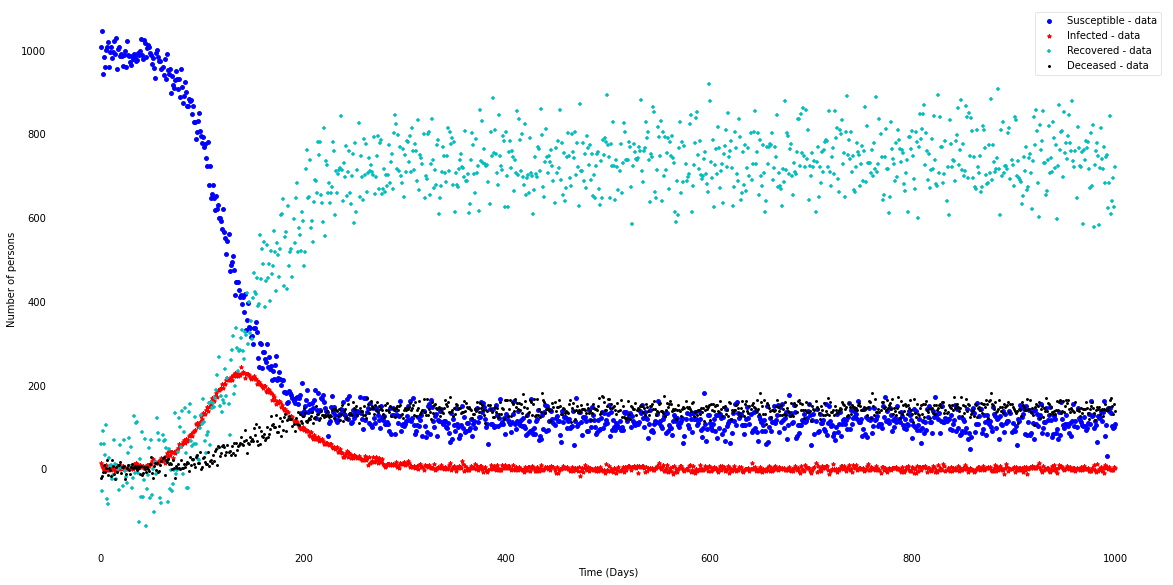

In [ ]:
t = np.linspace(0,len(Sd),len(Sd))

def SIRDplot(t, S, I, R, D):
  fig = plt.figure(facecolor='w',figsize=(20,10))
  ax = fig.add_subplot(111, axisbelow=True)
  plt.scatter(t, S, marker='o', color='b', label='Susceptible - data', s=15)
  plt.scatter(t, I, marker='*', color='r', label='Infected - data', s=15)
  plt.scatter(t, R, marker='+', color='c', label='Recovered - data', s=15)
  plt.scatter(t, D, marker='.', color='k', label='Deceased - data', s=15)
  ax.set_xlabel('Time (Days)')
  ax.set_ylabel('Number of persons')
  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend()
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  plt.show()

SIRDplot(t, Sd, Id, Rd, Dd)

## Minimization of the cost function

In [ ]:
(estimated_theta, kvg) = optimize.leastsq(Objective, theta)
print(estimated_theta)

[0.08854726 0.03038494 0.00592124]


## Comparison between Real Dataset and Fitted Model

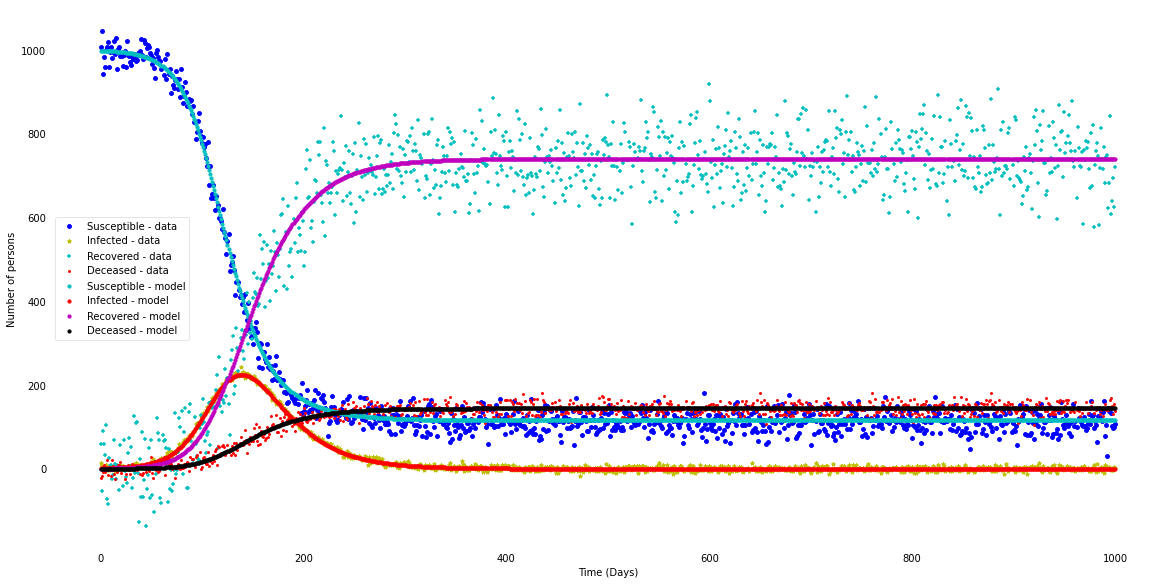

In [ ]:
[estimated_S,estimated_I,estimated_R,estimated_D] = SIRDsim(y0, t, N, estimated_theta)

t = np.linspace(0,len(Sd),len(Sd))
fig = plt.figure(facecolor='w',figsize=(20,10))
ax = fig.add_subplot(111, axisbelow=True)
plt.scatter(t, Sd, marker='o', color='b', label='Susceptible - data', s=15)
plt.scatter(t, Id, marker='*', color='y', label='Infected - data', s=15)
plt.scatter(t, Rd, marker='+', color='c', label='Recovered - data', s=15)
plt.scatter(t, Dd, marker='.', color='r', label='Deceased - data', s=15)
plt.scatter(t, estimated_S, color='c', label='Susceptible - model', s=10)
plt.scatter(t, estimated_I, color='r', label='Infected - model', s=10)
plt.scatter(t, estimated_R, color='m', label='Recovered - model', s=10)
plt.scatter(t, estimated_D, color='k', label='Deceased - model', s=10)
ax.set_xlabel('Time (Days)')
ax.set_ylabel('Number of persons')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Second Reverse Verification

> We went from a model to generate artificial Dataset, then we tried to estimate the parameters to fit the model to it.
>A good point would be to compare a second time the new estimated data to the model with the found parameters.

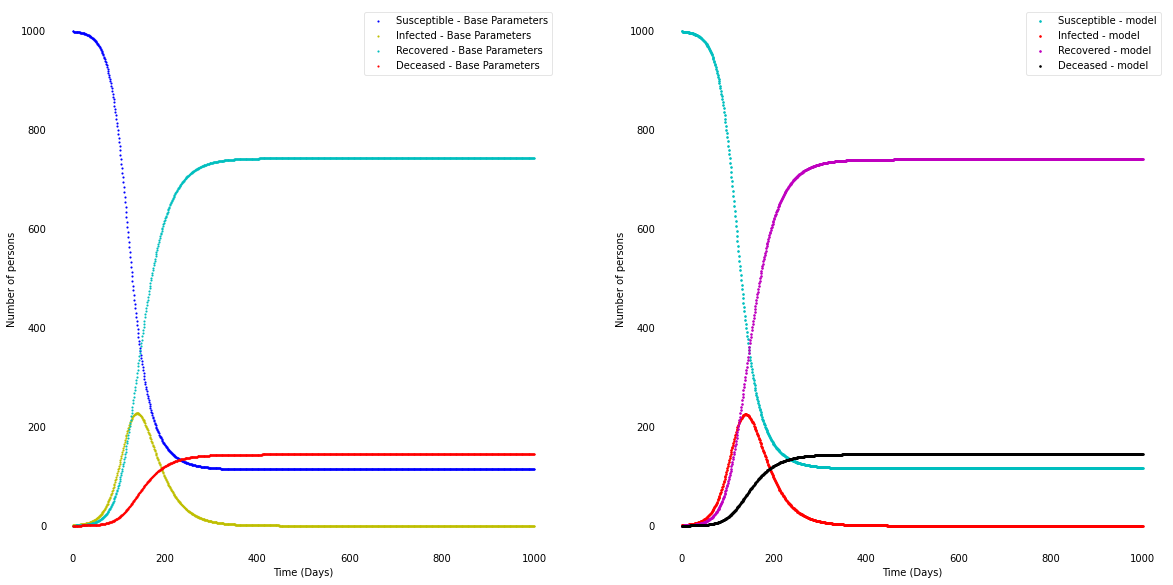

In [ ]:
t = np.linspace(0,len(Sd),len(Sd))

Second_S, Second_I, Second_R, Second_D = Simulated_data

fig = plt.figure(facecolor='w',figsize=(20,10))
ax = fig.add_subplot(121, axisbelow=True)
plt.scatter(t, Second_S,marker='.', color='b', label='Susceptible - Base Parameters', s=5)
plt.scatter(t, Second_I,marker='.', color='y', label='Infected - Base Parameters', s=5)
plt.scatter(t, Second_R,marker='.', color='c', label='Recovered - Base Parameters', s=5)
plt.scatter(t, Second_D,marker='.', color='r', label='Deceased - Base Parameters', s=5)
ax.set_xlabel('Time (Days)')
ax.set_ylabel('Number of persons')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

ax = fig.add_subplot(122, axisbelow=True)
plt.scatter(t, estimated_S,marker='.', color='c', label='Susceptible - model', s=10)
plt.scatter(t, estimated_I,marker='.', color='r', label='Infected - model', s=10)
plt.scatter(t, estimated_R,marker='.', color='m', label='Recovered - model', s=10)
plt.scatter(t, estimated_D,marker='.', color='k', label='Deceased - model', s=10)
ax.set_xlabel('Time (Days)')
ax.set_ylabel('Number of persons')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [ ]:
mt.r2_score(estimated_S,Second_S)

0.9999403317901958

## Consistancy Evaluation

On the previous figure, we can remark that proportional bunch of parameters (divided by 5) lead to similar plots. \\
To confirm this observation or not, using R^2 score is interesting.

In [ ]:
from sklearn import metrics as mt

theta1 = [0.4, 0.15, 0.05]
theta2 = [0.08, 0.03, 0.01]

N = 1000

y0 = [N-1, 1, 0, 0]

t = np.linspace(0, 200, 1000)

Try1 = SIRDsim(y0, t, N, theta1)

t = np.linspace(0, 1000, 1000)

Try2 = SIRDsim(y0, t, N, theta2)

mt.r2_score(Try1,Try2)

1.0

## Conclusion
>>As a Conclusion, we have created a method to fit the SIRD model to any dataset, in an accurately way. \\
This process is built on the **minimization of the Quadratic Error** by the **Least Squares Method**, to finally find the key parameters of the SIRD model. \\
Moreover, we can remark that the differentiel system has several solutions since we built the artificial Database with a set of parameters $\theta_0$, different from the one founded at the end. \\
However, the plotted datasets are corresponding each other no matter which solution we use. \\
Finally, this analyzis method may be applied in a lot of projects in the future. 